### Data exploration and loading common structures

In [4]:
import pandas as pd
import numpy as np
import csv as csv
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use('ggplot')
%matplotlib inline

In [18]:
# explore training data
train_df = pd.read_csv('../../data/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---

After counting the number of missing data in each column, we can discard 'Cabin' since it has very little information. Further, 'Ticket' is mostly specific to passengers and can also be removed. 

In [10]:
print("Number of unique 'Ticket' values = {0}".format(len(train_df['Ticket'].unique())))
print("---------------------------------------")
print("Missing values in each column")
print(train_df.isnull().sum())

---------------------------------------
Missing values in each column
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
age_ranges     177
dtype: int64


In [19]:
# remove the unhelpful features
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)

------------------- Distribution of Ages ---------------------------------


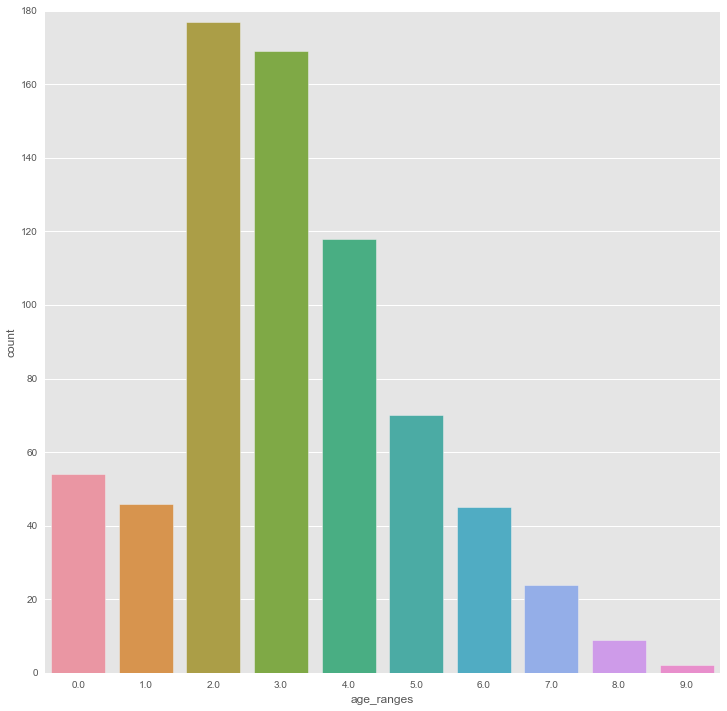

In [7]:
# distribution of age
print("------------------- Distribution of Ages ---------------------------------")
train_df['age_ranges'], age_bins = pd.cut(train_df['Age'], 10, precision=1, labels=False, retbins=True)
sns.factorplot('age_ranges', data=train_df, kind='count', size=10)
age_distribution = pd.concat((pd.DataFrame(age_bins, columns=["Age"]), train_df['age_ranges'].value_counts()), axis=1)
age_distribution.rename(columns={'age_ranges': 'Count'}, inplace=True)

In [20]:
# impute the missing Embarked and Age values
print("------------------- Imputing Embarked with mode value ---------------------------------")
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
print(train_df["Embarked"].value_counts(dropna=False))

print("------------------- Imputing Age with median ---------------------------------")
print("Median age = {0}".format(train_df["Age"].median()))
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())

------------------- Imputing Embarked with mode value ---------------------------------
S    646
C    168
Q     77
Name: Embarked, dtype: int64
------------------- Imputing Age with median ---------------------------------
Median age = 28.0


---

### Sex and Class correlation with survival

Below plot shows that most of the class 1 and 2 females survived, while majority of the male from class 3 did not survive.

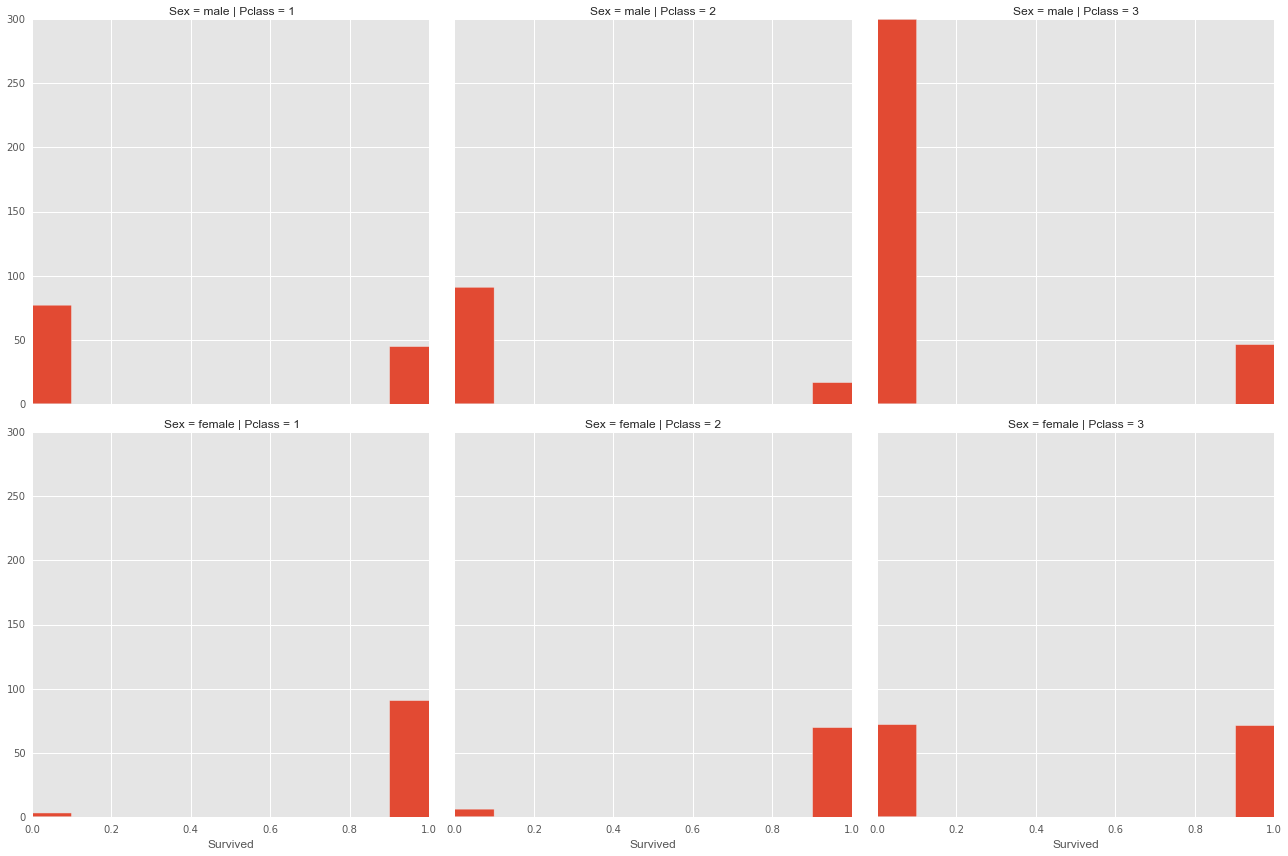

In [69]:
g = sns.FacetGrid(train_df, row="Sex", col="Pclass", col_order=[1, 2, 3], size=dddd6)
g.map(plt.hist, "Survived")


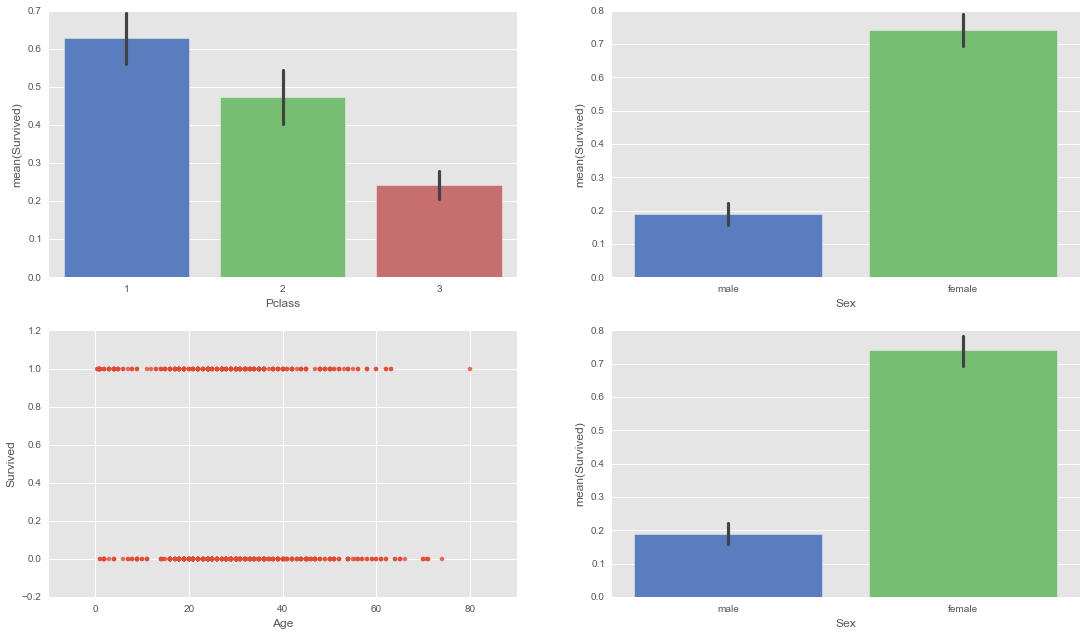

In [97]:
# Consider each feature individually
f, axes = plt.subplots(nrows=2, ncols=2)
g = sns.factorplot(x="Pclass", y="Survived",data=train_df,
                   size=6, kind="bar", palette="muted", order=[1, 2, 3], ax=axes[0, 0])
plt.close(g.fig)
g = sns.factorplot(x="Sex", y="Survived",data=train_df,
                   size=6, kind="bar", palette="muted", ax=axes[0, 1])
plt.close(g.fig)
g = sns.regplot(x="Age", y="Survived", fit_reg=False, data=train_df, ax=axes[1, 0])

g = sns.factorplot(x="Sex", y="Survived", data=train_df,
                   size=6, kind="bar", palette="muted", ax=axes[1, 1])
plt.close(g.fig)
f.set_size_inches(18.5, 10.5)



### Encoding the Sex and Embarked Column
    
We can convert the Embarked column to codes the same way we converted the Sex column. The unique values in Embarked are S, C, Q, and missing (nan). Each letter is an abbreviation of an embarkation port name.

We can dummy code the Embarked column to get numeric columns corresponding to the labels. 

In [22]:
# Replace all the occurences of male with the number 0.
train_df.loc[train_df["Sex"] == "male", "Sex"] = 0
train_df.loc[train_df["Sex"] == "female", "Sex"] = 1

# Find all the unique values for "Embarked".
print(train_df["Embarked"].unique())
train_df["Embarked"] = train_df["Embarked"].fillna('S')

embarked_dummy = pd.get_dummies(train_df["Embarked"], dummy_na=True, prefix="Embarked")
train_df = pd.concat([train_df, embarked_dummy], axis=1)
train_df.head()

['S' 'C' 'Q']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,0.0,0.0,1.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1.0,0.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,0.0,0.0,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,0.0,0.0,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,0.0,0.0,1.0,0.0


### Machine learning methods to predict survival

In [36]:
# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked_Q", "Embarked_S"]

# Create an acceptable formula for our machine learning algorithms
formula_ml = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)'

### Load test data

In [32]:
test_df = pd.read_csv("../../data/test.csv")

test_df['Age'] = test_df['Age'].fillna(train_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

embarked_test_dummy = pd.get_dummies(test_df["Embarked"], dummy_na=True, prefix="Embarked")
test_df = pd.concat([test_df, embarked_test_dummy], axis=1)

test_df.loc[test_df['Sex'] == 'male', 'Sex'] = 0
test_df.loc[test_df['Sex'] == 'female', 'Sex'] = 1

### Logistic regression

In [25]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute accuracy score for all the cross validation folds
scores = cross_validation.cross_val_score(
    alg, train_df[predictors], train_df["Survived"], cv=10)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.795800987402


In [35]:
# Train the algorithm using all the training data
alg = LogisticRegression(random_state=10)

alg.fit(train_df[predictors], train_df["Survived"])

# Make predictions using the test set
predictions = alg.predict(test_df[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": predictions
    })
submission.to_csv("../../submissions/self/log_regressor_1.csv", index=False)

In [ ]:
from sklearn import svm
from patsy import dmatrices

# Here you can output which ever result you would like by changing the Kernel and clf.predict lines
# Change kernel here to poly, rbf or linear
# adjusting the gamma level also changes the degree to which the model is fitted

# create a regression friendly data frame
formula_ml = 'Survived ~ C(Pclass) + C(Sex) + Age'
y_train, x_train = dmatrices(formula_ml, data=train_df, return_type='matrix')

clf = svm.SVC(kernel='poly', gamma=3).fit(x_train, y_train)                                                            
y, x = dmatrices(formula_ml, data=test_df, return_type='dataframe')

# Change the interger values within x.ix[:,[6,3]].dropna() explore the relationships between other 
# features. the ints are column postions. ie. [6,3] 6th column and the third column are evaluated. 
res_svm = clf.predict(x) 

res_svm = DataFrame(res_svm, columns=['Survived'])
res_svm.to_csv("../../submissions/self/svm_1.csv", index=False) 
print(res_svm)